In [1]:
import os
import torch
import copy
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from facenet_pytorch import MTCNN, InceptionResnetV1

# Initialize MTCNN for face detection
mtcnn = MTCNN(keep_all=True)


# Load pre-trained FaceNet model
resnet = InceptionResnetV1(pretrained='casia-webface').eval()

/work/VisualAnalytics/cds-vis/assignments/a4/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 111M/111M [00:00<00:00, 185MB/s]  


In [2]:
path = os.path.join("..","in","newspapers")
outpath = os.path.join("out")

In [15]:
results = []
for newspaper in os.listdir(path)[:1]:

    paper_path = sorted(os.listdir(os.path.join(path, newspaper)))

    for page in tqdm(paper_path[:50], position=0, leave=True):
        try:
            img = Image.open(os.path.join(path, newspaper, page))
        except OSError as image:
            print(f"Error processing image: {image}")

        boxes, _ = mtcnn.detect(img)
        results.append([page, boxes])

print(results)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:35<00:00,  1.42it/s]

[['JDG-1826-02-16-a-p0001.jpg', None], ['JDG-1826-02-16-a-p0002.jpg', None], ['JDG-1826-02-16-a-p0003.jpg', None], ['JDG-1826-02-16-a-p0004.jpg', None], ['JDG-1826-04-20-a-p0001.jpg', None], ['JDG-1826-04-20-a-p0002.jpg', None], ['JDG-1826-04-20-a-p0003.jpg', None], ['JDG-1826-04-20-a-p0004.jpg', None], ['JDG-1826-06-15-a-p0001.jpg', None], ['JDG-1826-06-15-a-p0002.jpg', None], ['JDG-1826-06-15-a-p0003.jpg', None], ['JDG-1826-06-15-a-p0004.jpg', None], ['JDG-1829-03-26-a-p0001.jpg', None], ['JDG-1829-03-26-a-p0002.jpg', None], ['JDG-1829-03-26-a-p0003.jpg', None], ['JDG-1829-03-26-a-p0004.jpg', None], ['JDG-1829-04-16-a-p0001.jpg', None], ['JDG-1829-04-16-a-p0002.jpg', None], ['JDG-1829-04-16-a-p0003.jpg', None], ['JDG-1829-04-16-a-p0004.jpg', None], ['JDG-1829-07-23-a-p0001.jpg', None], ['JDG-1829-07-23-a-p0002.jpg', None], ['JDG-1829-07-23-a-p0003.jpg', None], ['JDG-1829-07-23-a-p0004.jpg', None], ['JDG-1829-07-23-a-p0005.jpg', None], ['JDG-1829-07-23-a-p0006.jpg', None], ['JDG-1831-

In [16]:
results_ = results.copy()

In [17]:
# count pages w/ faces and sum of all faces

sum_of_faces = 0
face_page_sum = 0

for obj in results_:
    if obj[1] is None:
        obj[1] = 0
    else:
        sum_of_faces += len(obj[1])
        face_page_sum += 1
        obj[1] = len(obj[1])

print(f'Faces detected: {sum_of_faces}')
print(f'Pages with faces: {face_page_sum}')

Faces detected: 0
Pages with faces: 0


In [18]:
df = pd.DataFrame(results_, columns=['Pages', 'Faces freq.'])

In [43]:
df['Year'] = df['Pages'].str.extract(r'-(\d{4})-').astype(int)
df['Paper'] = df['Pages'].str.extract(r'^([A-Z]{3})-').astype(str)

df['Decade'] = (df['Year'] // 10) * 10

df_sorted = df.sort_values('Decade')

grouped_df = df_sorted.groupby(['Decade', 'Paper']).agg({
    'Faces freq.':'sum',
    'Pages': 'count',
}).reset_index()

grouped_df['% of pages'] = (grouped_df['Faces freq.'] / grouped_df['Pages']) * 100
grouped_df['% of pages'] = grouped_df['% of pages'].round(2)
grouped_df
csv = pd.read_csv(os.path.join(outpath, "data.csv"))
papers = grouped_df['Paper'].unique()
#grouped_df.to_csv(os.path.join("..","out","data.csv"), index=False)

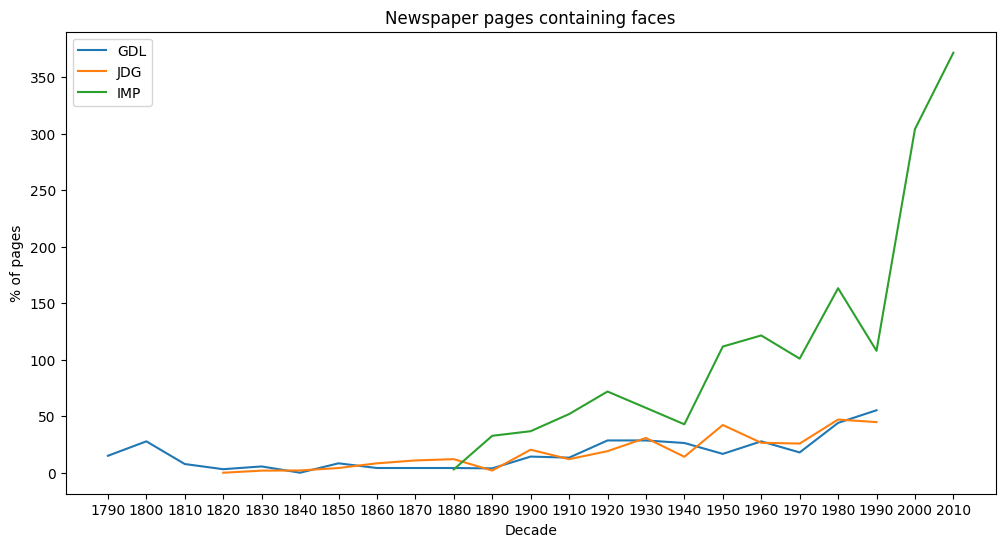

In [16]:
grouped_df = pd.read_csv(os.path.join("..","out", "data.csv"))
papers = grouped_df['Paper'].unique()
plt.figure(figsize=(12, 6))
for paper in papers:
    paper_df = grouped_df[grouped_df['Paper'] == paper]
    plt.plot(paper_df['Decade'], paper_df['% of pages'], label=paper)
plt.xticks(grouped_df['Decade'].unique(), grouped_df['Decade'].unique())
plt.xlabel('Decade')
plt.ylabel('% of pages')
plt.title('Newspaper pages containing faces')
plt.legend()
plt.show()
